In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

Conexion hacia el SNOWFLAKE

In [60]:
#snowflake connection
import snowflake.connector
import os

conn=snowflake.connector.connect(

    user=os.getenv('SNOWFLAKE_USERNAME'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account='zsb67146.us-east-1',
    warehouse='COMPUTE_WH',
    database='PROYECTO1',
    schema='RAW'

)

Guardado de tablas

In [61]:
list_tables_query = 'SHOW TABLES'
tables = pd.read_sql(list_tables_query, conn)
print(tables)

C:\Users\elian\AppData\Local\Temp\ipykernel_17756\1362887654.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tables = pd.read_sql(list_tables_query, conn)


                        created_on         name database_name schema_name  \
0 2025-02-12 06:01:43.602000+00:00       AISLES     PROYECTO1         RAW   
1 2025-02-12 06:01:49.021000+00:00  DEPARTMENTS     PROYECTO1         RAW   
2 2025-02-12 06:02:04.210000+00:00    INSTACART     PROYECTO1         RAW   
3 2025-02-12 06:02:28.195000+00:00       ORDERS     PROYECTO1         RAW   
4 2025-02-12 06:02:44.855000+00:00     PRODUCTS     PROYECTO1         RAW   

    kind comment cluster_by     rows     bytes         owner  ...  \
0  TABLE                         134      3072  ACCOUNTADMIN  ...   
1  TABLE                          21      1536  ACCOUNTADMIN  ...   
2  TABLE                      478967   3629056  ACCOUNTADMIN  ...   
3  TABLE                     4545007  25421824  ACCOUNTADMIN  ...   
4  TABLE                       49694   1080832  ACCOUNTADMIN  ...   

  search_optimization_bytes is_external enable_schema_evolution  \
0                      None           N                

In [62]:

conn.cursor().execute("USE DATABASE PROYECTO1")
conn.cursor().execute("USE SCHEMA CLEAN")

In [63]:
#query to get the data from the table

names= ['FACT_INSTACART', 'FACT_ORDER', 'PRODUCTSDIM']

tables={}

for name in names:
   query= f"select * from {name}"
   tables[name]=pd.read_sql(query,conn)

C:\Users\elian\AppData\Local\Temp\ipykernel_17756\1529624349.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tables[name]=pd.read_sql(query,conn)


In [64]:
for name in names:
    print(f"Shape of {name} table is {tables[name].shape}")

Shape of FACT_INSTACART table is (478952, 6)
Shape of FACT_ORDER table is (4544171, 4)
Shape of PRODUCTSDIM table is (48436, 4)


In [65]:
fctInstacart=tables["FACT_INSTACART"]
fctInstacart.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1515936,183418,11,6,13,30.0
1,1690866,163593,5,5,12,9.0
2,1454967,39980,4,5,19,2.0
3,1768857,82516,56,0,20,10.0
4,3007858,196724,2,4,12,17.0


In [66]:
fctOrder=tables["FACT_ORDER"]
fctOrder.head()

,order_id,product_id,add_to_cart_order,reordered
0,2720735,16209,13.0,0
1,1502313,23646,4.0,0
2,2527031,36076,16.0,1
3,2273090,25890,10.0,1
4,3124164,13176,1.0,0


In [67]:
productsDim=tables["PRODUCTSDIM"]   
productsDim.head()

,product_id,product_name,aisle_name,department_name
0,1,Chocolate Sandwich Cookies,prepared soups salads,frozen
1,2,All-Seasons Salt,specialty cheeses,other
2,3,Robust Golden Unsweetened Oolong Tea,energy granola bars,bakery
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,instant foods,produce
4,5,Green Chile Anytime Sauce,marinades meat preparation,alcohol


CONSULTAS

1. Comportamiento de compra según día de la semana

In [68]:
semanaDict = {
    "LUNES": fctInstacart[fctInstacart["order_dow"] == 0],
    "MARTES": fctInstacart[fctInstacart["order_dow"] == 1],
    "MIERCOLES": fctInstacart[fctInstacart["order_dow"] == 2],
    "JUEVES": fctInstacart[fctInstacart["order_dow"] == 3],
    "VIERNES": fctInstacart[fctInstacart["order_dow"] == 4],
    "SABADO": fctInstacart[fctInstacart["order_dow"] == 5],
    "DOMINGO": fctInstacart[fctInstacart["order_dow"] == 6],
}

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]



In [69]:
averages = [[] for _ in range(3)]  

for name in semanaDict:
    temp=pd.DataFrame(semanaDict[name])

    size=len(temp)
    averages[0].append(size)

    avgHR = temp["order_hour_of_day"].mean()
    averages[1].append(avgHR)

    avgPriorOrder = temp["days_since_prior_order"].mean()
    averages[2].append(avgPriorOrder)



Graficos

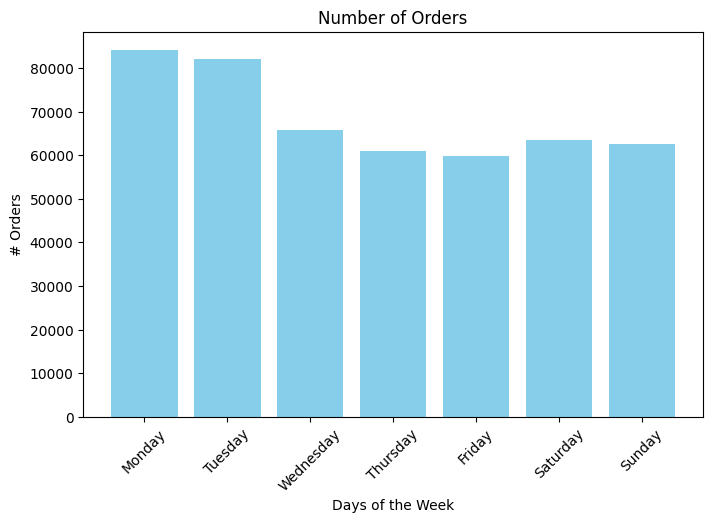

In [70]:
plt.figure(figsize=(8, 5))
plt.bar(days, averages[0], color="skyblue")

# Add labels and title
plt.xlabel("Days of the Week")
plt.ylabel("# Orders")
plt.title("Number of Orders")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the graph
plt.show()

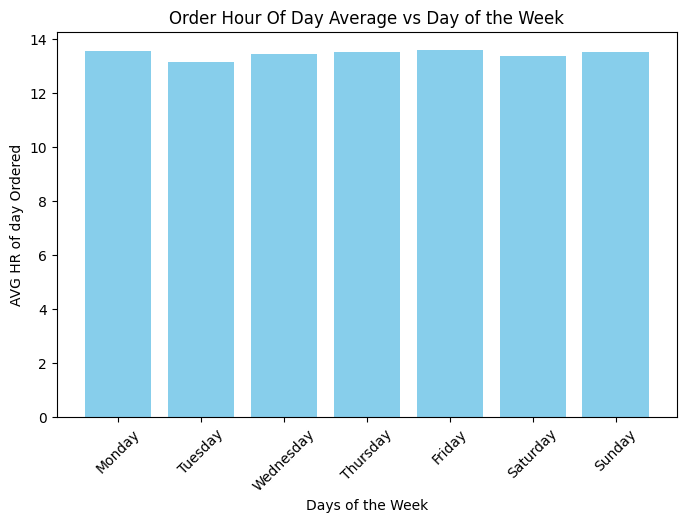

In [71]:
plt.figure(figsize=(8, 5))
plt.bar(days, averages[1], color="skyblue")

# Add labels and title
plt.xlabel("Days of the Week")
plt.ylabel("AVG HR of day Ordered")
plt.title("Order Hour Of Day Average vs Day of the Week")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the graph
plt.show()

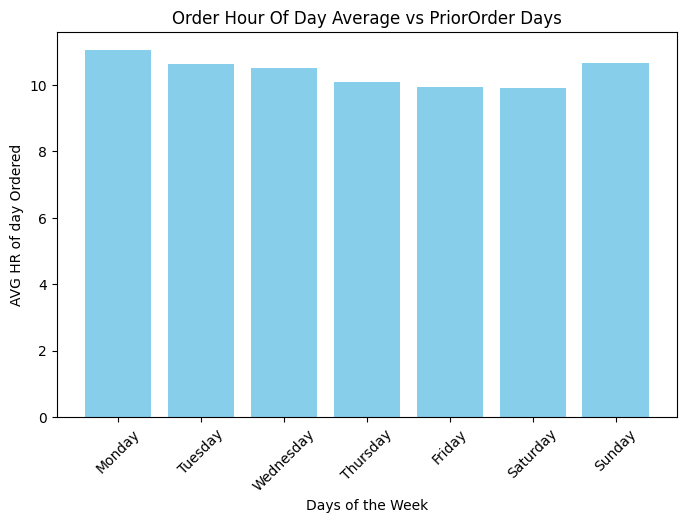

In [72]:
plt.figure(figsize=(8, 5))
plt.bar(days, averages[2], color="skyblue")

# Add labels and title
plt.xlabel("Days of the Week")
plt.ylabel("AVG HR of day Ordered")
plt.title("Order Hour Of Day Average vs PriorOrder Days")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the graph
plt.show()

2. Comportamiento de compra según hora del día

In [73]:
fctInstacart

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1515936,183418,11,6,13,30.0
1,1690866,163593,5,5,12,9.0
2,1454967,39980,4,5,19,2.0
3,1768857,82516,56,0,20,10.0
4,3007858,196724,2,4,12,17.0
...,...,...,...,...,...,...
478947,3210681,5617,5,1,14,7.0
478948,3270802,112087,2,3,13,6.0
478949,885349,82944,16,2,11,6.0
478950,216274,4391,3,3,8,8.0


In [74]:
hourSize = []

for i in range(24):
    df=fctInstacart["order_hour_of_day"][fctInstacart["order_hour_of_day"]==i]
    size=df.size
    hourSize.append(size)

print(hourSize)

[3180, 1763, 989, 770, 765, 1371, 4215, 13043, 25024, 35896, 40578, 40032, 38034, 39007, 39631, 39789, 38112, 31930, 25510, 19547, 14624, 11019, 8512, 5611]


In [75]:
hrs=list(range(24))

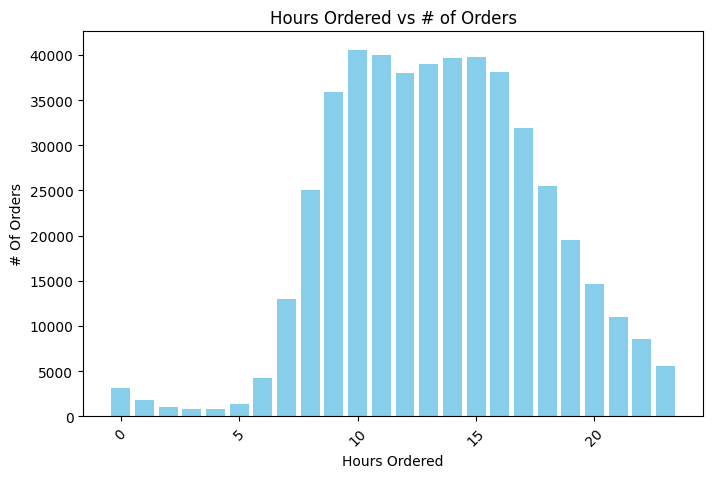

In [76]:


plt.figure(figsize=(8, 5))
plt.bar(hrs, hourSize, color="skyblue")

# Add labels and title
plt.xlabel("Hours Ordered")
plt.ylabel("# Of Orders")
plt.title("Hours Ordered vs # of Orders")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the graph
plt.show()

3. Comportamiento según hora del día y día de la semana



In [77]:
hourSizeDays=[]

for name in semanaDict:

    dfDia=pd.DataFrame(semanaDict[name])
    hourSize=[]

    for i in range(24):
        size=(dfDia["order_hour_of_day"] == i).sum()
        hourSize.append(size)
        
    hourSizeDays.append(hourSize)



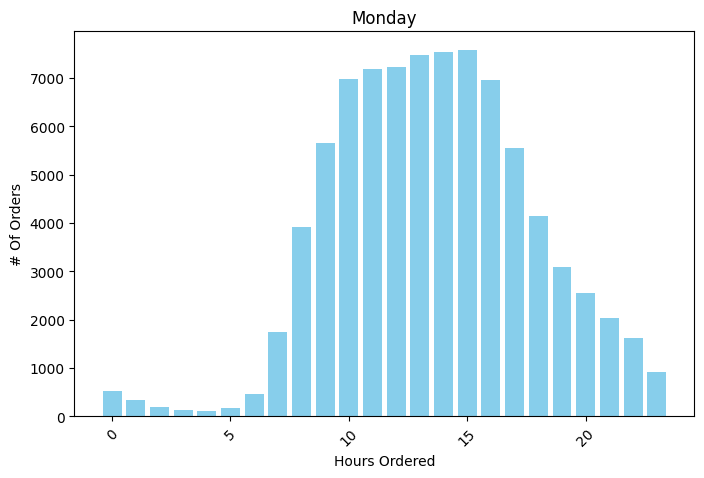

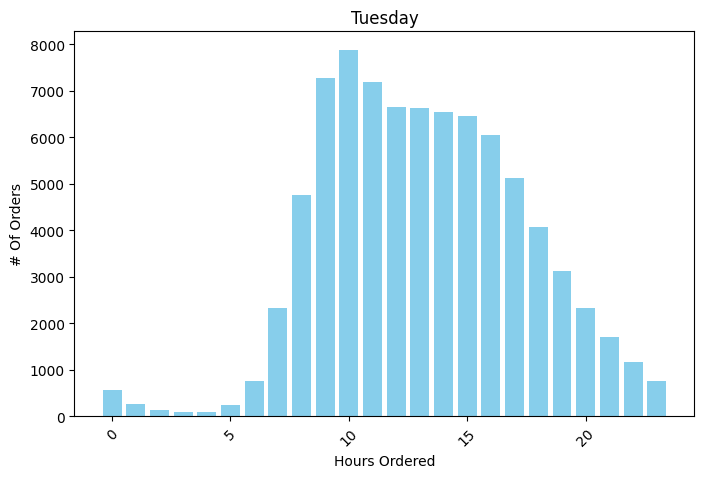

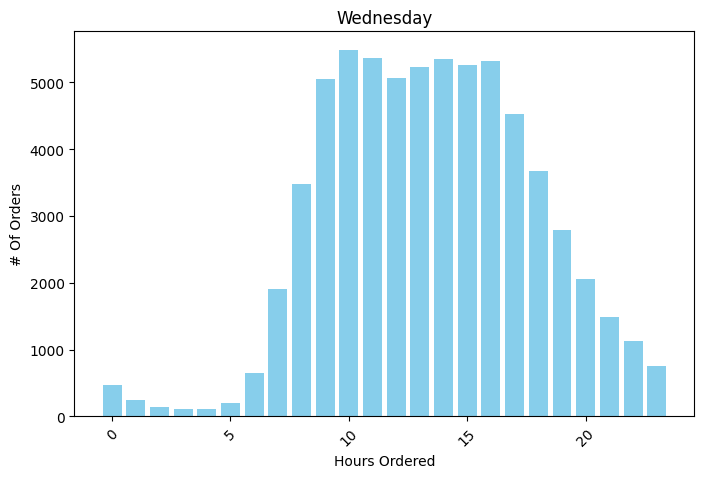

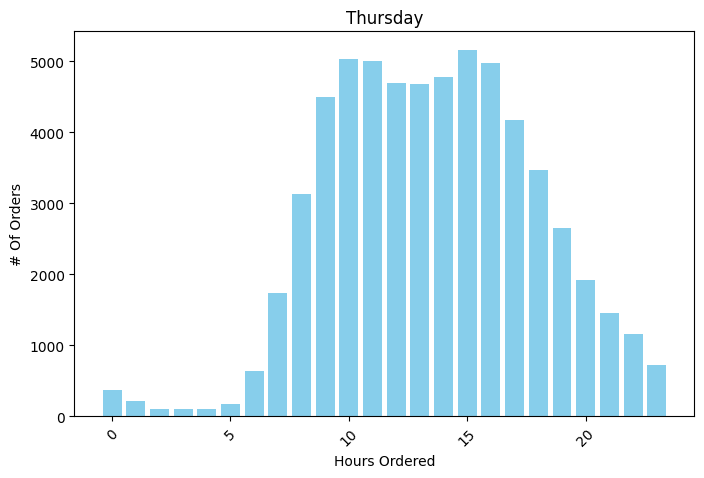

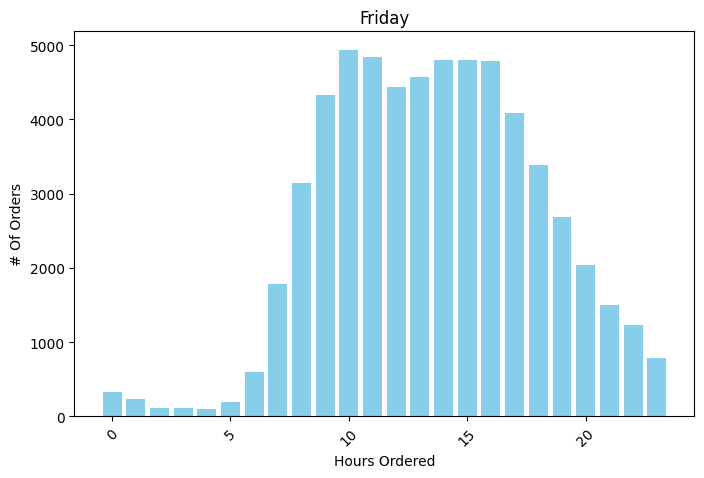

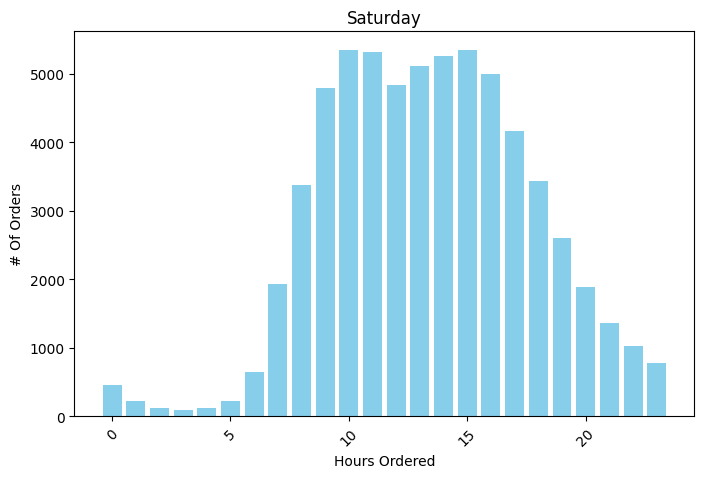

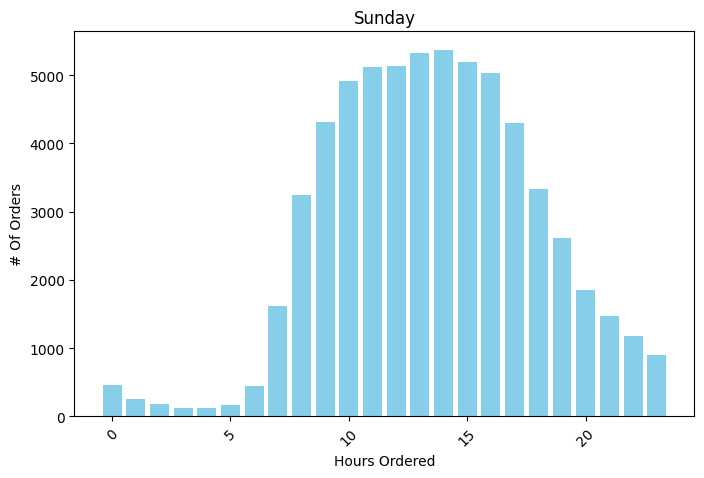

In [78]:
for i, day in enumerate(days):

    plt.figure(figsize=(8, 5))
    plt.bar(hrs, hourSizeDays[i], color="skyblue")

    # Add labels and title
    plt.xlabel("Hours Ordered")
    plt.ylabel("# Of Orders")
    plt.title(day)
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability

    # Show the graph
    plt.show()

4. Distribución de las órdenes hechas por los clientes


In [98]:
fctOrder

,order_id,product_id,add_to_cart_order,reordered
0,2720735,16209,13.0,0
1,1502313,23646,4.0,0
2,2527031,36076,16.0,1
3,2273090,25890,10.0,1
4,3124164,13176,1.0,0
...,...,...,...,...
4544166,1212677,27143,4.0,1
4544167,1109226,43961,5.0,0
4544168,576060,37417,2.0,1
4544169,1545254,21137,3.0,0


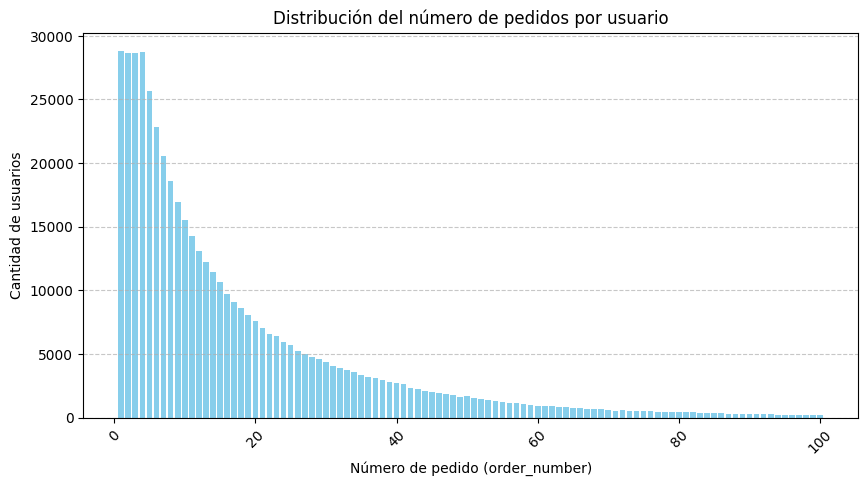

In [ ]:
df = pd.DataFrame(fctInstacart)

order_distribution = df["order_number"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(order_distribution.index, order_distribution.values, color="skyblue")
plt.xlabel("Número de pedido (order_number)")
plt.ylabel("Cantidad de usuarios")
plt.title("Distribución del número de pedidos por usuario")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


5. Top 20 productos más frecuentes

In [79]:
mostCommon20=Counter(fctOrder["product_id"]).most_common(20)
mostCommon20


[(24852, 66046),
 (13176, 53295),
 (21137, 37035),
 (21903, 33970),
 (47209, 29772),
 (47766, 24689),
 (47626, 21495),
 (16797, 20017),
 (26209, 19689),
 (27845, 19600),
 (27966, 19194),
 (22935, 15897),
 (24964, 15290),
 (45007, 14584),
 (39275, 13879),
 (49683, 13674),
 (28204, 12544),
 (5876, 12231),
 (8277, 11992),
 (40706, 11781)]

In [80]:
for i, (product_id, count) in enumerate(mostCommon20):
    
    result = productsDim.loc[productsDim["product_id"] == product_id, "product_name"].values[0]
    mostCommon20[i] = (result, count)
    
print(mostCommon20)

[('Banana', 66046), ('Bag of Organic Bananas', 53295), ('Organic Strawberries', 37035), ('Organic Baby Spinach', 33970), ('Organic Hass Avocado', 29772), ('Organic Avocado', 24689), ('Large Lemon', 21495), ('Strawberries', 20017), ('Limes', 19689), ('Organic Whole Milk', 19600), ('Organic Raspberries', 19194), ('Organic Yellow Onion', 15897), ('Organic Garlic', 15290), ('Organic Zucchini', 14584), ('Organic Blueberries', 13879), ('Cucumber Kirby', 13674), ('Organic Fuji Apple', 12544), ('Organic Lemon', 12231), ('Apple Honeycrisp Organic', 11992), ('Organic Grape Tomatoes', 11781)]


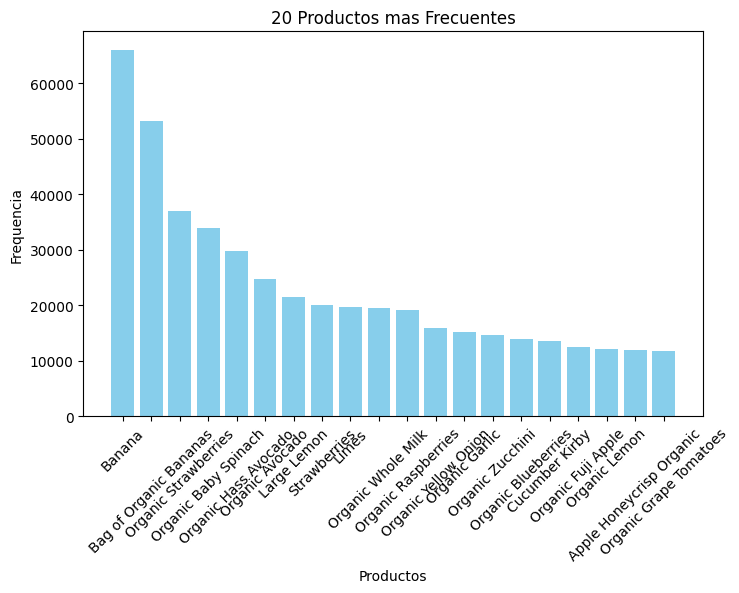

[('Banana', 66046),
 ('Bag of Organic Bananas', 53295),
 ('Organic Strawberries', 37035),
 ('Organic Baby Spinach', 33970),
 ('Organic Hass Avocado', 29772),
 ('Organic Avocado', 24689),
 ('Large Lemon', 21495),
 ('Strawberries', 20017),
 ('Limes', 19689),
 ('Organic Whole Milk', 19600),
 ('Organic Raspberries', 19194),
 ('Organic Yellow Onion', 15897),
 ('Organic Garlic', 15290),
 ('Organic Zucchini', 14584),
 ('Organic Blueberries', 13879),
 ('Cucumber Kirby', 13674),
 ('Organic Fuji Apple', 12544),
 ('Organic Lemon', 12231),
 ('Apple Honeycrisp Organic', 11992),
 ('Organic Grape Tomatoes', 11781)]

In [81]:

names,freq=zip(*mostCommon20)

plt.figure(figsize=(8, 5))
plt.bar(names, freq, color="skyblue")

    # Add labels and title
plt.xlabel("Productos")
plt.ylabel("Frequencia")
plt.title("20 Productos mas Frecuentes")
plt.xticks(rotation=45)  

plt.show()

mostCommon20

6. ¿Cuántos artículos se compran generalmente en un pedido?

In [82]:
meanArticulos = fctOrder.groupby("order_id")["product_id"].count().mean()
print(f"Se compran en cada orden alrededor de {meanArticulos} articulos")


Se compran en cada orden alrededor de 10.097125627158112 articulos


7. Top 20 artículos que se vuelven a pedir con más frecuencia

In [83]:
df=fctOrder.loc[fctOrder["reordered"]==1,"product_id"]
frequencyReordered=Counter(df).most_common(20)

frequencyReordered


[(24852, 55761),
 (13176, 44448),
 (21137, 28637),
 (21903, 26232),
 (47209, 23628),
 (47766, 18743),
 (27845, 16251),
 (47626, 15044),
 (27966, 14747),
 (16797, 13944),
 (26209, 13326),
 (22935, 11144),
 (24964, 10409),
 (45007, 10076),
 (49683, 9538),
 (28204, 8989),
 (8277, 8835),
 (39275, 8799),
 (5876, 8411),
 (49235, 8389)]

In [84]:

for i, (product_id, count) in enumerate(frequencyReordered):
    
    result = productsDim.loc[productsDim["product_id"] == product_id, "product_name"].values[0]
    frequencyReordered[i] = (result, count)
    

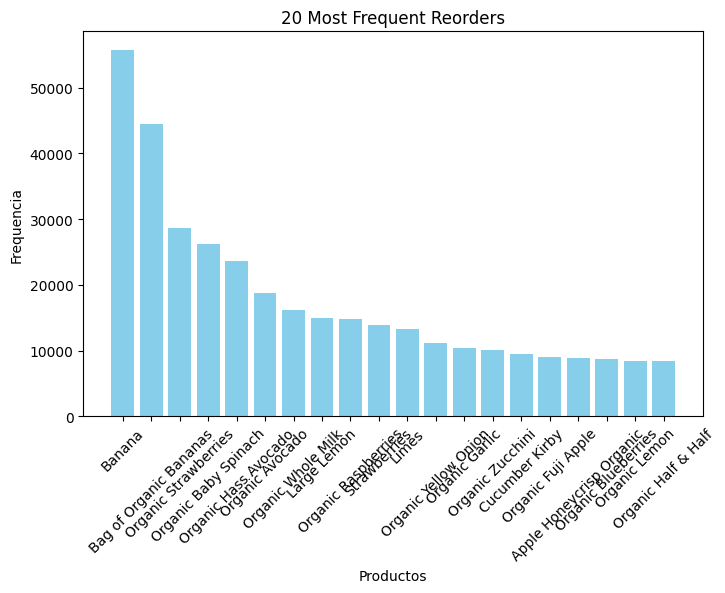

[('Banana', 66046),
 ('Bag of Organic Bananas', 53295),
 ('Organic Strawberries', 37035),
 ('Organic Baby Spinach', 33970),
 ('Organic Hass Avocado', 29772),
 ('Organic Avocado', 24689),
 ('Large Lemon', 21495),
 ('Strawberries', 20017),
 ('Limes', 19689),
 ('Organic Whole Milk', 19600),
 ('Organic Raspberries', 19194),
 ('Organic Yellow Onion', 15897),
 ('Organic Garlic', 15290),
 ('Organic Zucchini', 14584),
 ('Organic Blueberries', 13879),
 ('Cucumber Kirby', 13674),
 ('Organic Fuji Apple', 12544),
 ('Organic Lemon', 12231),
 ('Apple Honeycrisp Organic', 11992),
 ('Organic Grape Tomatoes', 11781)]

In [85]:
names,freq=zip(*frequencyReordered)

plt.figure(figsize=(8, 5))
plt.bar(names, freq, color="skyblue")

    # Add labels and title
plt.xlabel("Productos")
plt.ylabel("Frequencia")
plt.title("20 Most Frequent Reorders")
plt.xticks(rotation=45)  

plt.show()

mostCommon20

8. Proporción de pedidos que se vuelven a pedir para cada producto

In [86]:

df = fctOrder

reorder_counts = df.groupby("product_id")["reordered"].sum()
total_counts = df.groupby("product_id")["reordered"].count()

proportion_reordered = reorder_counts / total_counts

result = proportion_reordered.reset_index()
result.columns = ["product_id", "reorder_proportion"]
result


,product_id,reorder_proportion
0,1,0.564286
1,2,0.000000
2,3,0.738095
3,4,0.510204
4,7,0.500000
...,...,...
45567,49690,0.800000
45568,49691,0.430556
45569,49692,0.416667
45570,49693,0.440000


9. Proporción de productos pedidos que se vuelven a pedir para cada cliente


In [87]:

merged_df = fctOrder.merge(fctInstacart[["order_id", "user_id"]], on="order_id")


In [88]:

total_products_per_user = merged_df.groupby("user_id")["product_id"].count()
reordered_products_per_user = merged_df[merged_df["reordered"] == 1].groupby("user_id")["product_id"].count()


In [89]:

reorder_proportion = (reordered_products_per_user / total_products_per_user).fillna(0)

In [90]:

# Convert to DataFrame for better readability
result = reorder_proportion.reset_index()
result.columns = ["user_id", "reorder_proportion"]

result

,user_id,reorder_proportion
0,2,0.038462
1,4,0.000000
2,5,0.666667
3,6,0.000000
4,7,0.928571
...,...,...
149621,206203,0.222222
149622,206206,0.714286
149623,206207,0.891304
149624,206208,0.696000


10. Top 20 artículos que la gente pone primero en el carrito

In [91]:
df=fctOrder[fctOrder["add_to_cart_order"]==1]
df=df["product_id"]
firstSpotFrequency=Counter(df).most_common(20)
firstSpotFrequency


[(24852, 15562),
 (13176, 11026),
 (27845, 4363),
 (21137, 3946),
 (47209, 3390),
 (21903, 3336),
 (47766, 3044),
 (19660, 2336),
 (16797, 2308),
 (27966, 2024),
 (44632, 1914),
 (49235, 1797),
 (47626, 1737),
 (196, 1733),
 (38689, 1397),
 (26209, 1370),
 (12341, 1340),
 (5785, 1310),
 (27086, 1309),
 (43352, 1246)]

In [92]:

for i, (product_id, count) in enumerate(firstSpotFrequency):
    
    result = productsDim.loc[productsDim["product_id"] == product_id, "product_name"].values[0]
    firstSpotFrequency[i] = (result, count)

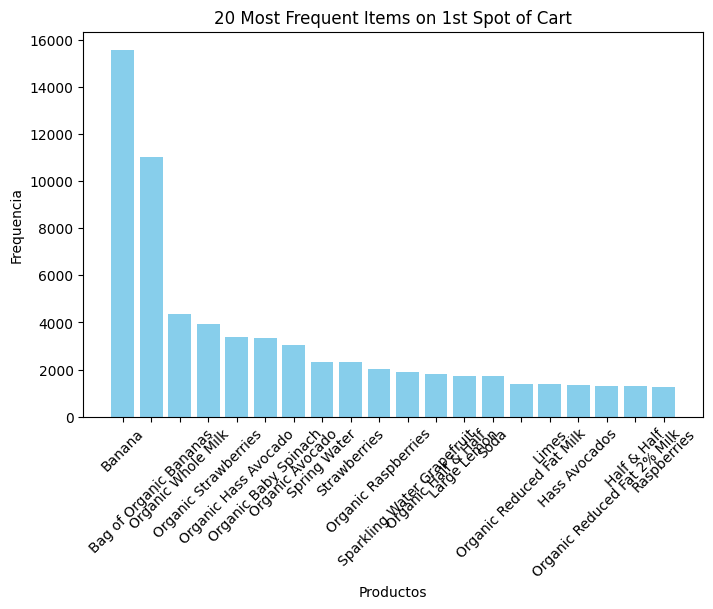

[('Banana', 15562),
 ('Bag of Organic Bananas', 11026),
 ('Organic Whole Milk', 4363),
 ('Organic Strawberries', 3946),
 ('Organic Hass Avocado', 3390),
 ('Organic Baby Spinach', 3336),
 ('Organic Avocado', 3044),
 ('Spring Water', 2336),
 ('Strawberries', 2308),
 ('Organic Raspberries', 2024),
 ('Sparkling Water Grapefruit', 1914),
 ('Organic Half & Half', 1797),
 ('Large Lemon', 1737),
 ('Soda', 1733),
 ('Organic Reduced Fat Milk', 1397),
 ('Limes', 1370),
 ('Hass Avocados', 1340),
 ('Organic Reduced Fat 2% Milk', 1310),
 ('Half & Half', 1309),
 ('Raspberries', 1246)]

In [93]:
names,freq=zip(*firstSpotFrequency)

plt.figure(figsize=(8, 5))
plt.bar(names, freq, color="skyblue")

    # Add labels and title
plt.xlabel("Productos")
plt.ylabel("Frequencia")
plt.title("20 Most Frequent Items on 1st Spot of Cart")
plt.xticks(rotation=45)  

plt.show()

firstSpotFrequency